In [1]:
import pandas as pd 
import os
import numpy as np
import pickle
from matplotlib_venn import venn2
from matplotlib import pyplot as plt
from tqdm import tqdm
import matplotlib
import string
from matplotlib.lines import Line2D
from matplotlib import font_manager

In [2]:
libdir = '../data/lib/'
libname = 'ecolihumanyeast_concat_mayu_IRR_cons_openswath_64var_curated_norm.pkl'
with open(os.path.join(libdir,libname),'rb')as f:
    library = pickle.load(f)

In [3]:
dirname = "../result/"
filenames_A = [
    'CsoDIAq-file1_480_20210929_noRT_FAIMS_30to80_120ms_40min_250nL_A_1_correctedNoFilter_withFeature_13cycle_5_1_LDA_ID_Coeffs.csv',
    'CsoDIAq-file2_480_20210929_noRT_FAIMS_30to80_120ms_40min_250nL_A_2_correctedNoFilter_withFeature_13cycle_5_1_LDA_ID_Coeffs.csv',
    'CsoDIAq-file3_480_20210929_noRT_FAIMS_30to80_120ms_40min_250nL_A_3_correctedNoFilter_withFeature_13cycle_5_1_LDA_ID_Coeffs.csv',
    'CsoDIAq-file4_480_20210929_noRT_FAIMS_30to80_120ms_40min_250nL_A_4_correctedNoFilter_withFeature_13cycle_5_1_LDA_ID_Coeffs.csv',
    'CsoDIAq-file5_480_20210929_noRT_FAIMS_30to80_120ms_40min_250nL_A_5_correctedNoFilter_withFeature_13cycle_5_1_LDA_ID_Coeffs.csv',
]
filenames_B = [
    'CsoDIAq-file6_480_20210929_noRT_FAIMS_30to80_120ms_40min_250nL_B_1_correctedNoFilter_withFeature_13cycle_5_1_LDA_ID_Coeffs.csv',
    'CsoDIAq-file7_480_20210929_noRT_FAIMS_30to80_120ms_40min_250nL_B_2_correctedNoFilter_withFeature_13cycle_5_1_LDA_ID_Coeffs.csv',
    'CsoDIAq-file8_480_20210929_noRT_FAIMS_30to80_120ms_40min_250nL_B_3_correctedNoFilter_withFeature_13cycle_5_1_LDA_ID_Coeffs.csv',
    'CsoDIAq-file9_480_20210929_noRT_FAIMS_30to80_120ms_40min_250nL_B_4_correctedNoFilter_withFeature_13cycle_5_1_LDA_ID_Coeffs.csv',
    'CsoDIAq-file10_480_20210929_noRT_FAIMS_30to80_120ms_40min_250nL_B_5_correctedNoFilter_withFeature_13cycle_5_1_LDA_ID_Coeffs.csv',
]

In [4]:
def peptide_type(x):
    if x.startswith('DECOY-'):
        return 'DECOY_null'
    elif x.startswith('TRAP-'):
        return 'TRAP'
    else:
        return 'SAMPLE'

In [5]:
total_A = pd.DataFrame([])
for i in range(len(filenames_A)):
    df = pd.read_csv(os.path.join(dirname,filenames_A[i]))
    df['Precursor'] = df[['peptide','charge']].apply(lambda x:x['peptide']+'_'+str(x['charge']),axis=1)
    df['protein'] = df['peptide'].apply(peptide_type)
    df = df[df['protein']=='SAMPLE']
    df = df[df['Coeff']>0]
    df['A'+str(i+1)] = df['Coeff']
    df = df[['Precursor','A'+str(i+1)]]
    if i==0:
        total_A = pd.concat([total_A,df])
    else:
        total_A = total_A.join(df.set_index('Precursor'),on='Precursor',how='outer')

In [6]:
total_B = pd.DataFrame([])
for i in range(len(filenames_B)):
    df = pd.read_csv(os.path.join(dirname,filenames_B[i]))
    df['Precursor'] = df[['peptide','charge']].apply(lambda x:x['peptide']+'_'+str(x['charge']),axis=1)
    df['protein'] = df['peptide'].apply(peptide_type)
    df = df[df['protein']=='SAMPLE']
    df = df[df['Coeff']>0]
    df['B'+str(i+1)] = df['Coeff']
    df = df[['Precursor','B'+str(i+1)]]
    if i==0:
        total_B = pd.concat([total_B,df])
    else:
        total_B = total_B.join(df.set_index('Precursor'),on='Precursor',how='outer')

In [7]:
# # at least 2 identifications in 5 replicates.
# total_A['num_of_nan'] = total_A.T.isna().sum()
# total_A = total_A[total_A['num_of_nan']<=3]
# total_B['num_of_nan'] = total_B.T.isna().sum()
# total_B = total_B[total_B['num_of_nan']<=3]

In [8]:
# at least 4 identifications in 5 replicates.
total_A['num_of_nan'] = total_A.T.isna().sum()
total_A = total_A[total_A['num_of_nan']<=1]
total_B['num_of_nan'] = total_B.T.isna().sum()
total_B = total_B[total_B['num_of_nan']<=1]

In [9]:
def get_avg_A(x):
    coeffs = []
    for i in range(5):
        coeff = x['A'+str(i+1)]
        if coeff>0:
            coeffs.append(coeff)
        else:
            pass
    return np.mean(coeffs)
def get_CV_A(x):
    coeffs = []
    for i in range(5):
        coeff = x['A'+str(i+1)]
        if coeff>0:
            coeffs.append(coeff)
        else:
            pass
    return np.std(coeffs)/np.mean(coeffs)
def get_avg_B(x):
    coeffs = []
    for i in range(5):
        coeff = x['B'+str(i+1)]
        if coeff>0:
            coeffs.append(coeff)
        else:
            pass
    return np.mean(coeffs)
def get_CV_B(x):
    coeffs = []
    for i in range(5):
        coeff = x['B'+str(i+1)]
        if coeff>0:
            coeffs.append(coeff)
        else:
            pass
    return np.std(coeffs)/np.mean(coeffs)

In [10]:
total_A['peptide'] = total_A['Precursor'].apply(lambda x:x.split('_')[0])
total_A_pep = total_A.groupby('peptide').sum().reset_index()
total_A_pep = total_A_pep.drop('num_of_nan',axis=1)
# total_A_pep['avg'] = total_A_pep[['A1','A2','A3','A4','A5']].apply(get_avg_A,axis=1)
# total_A_pep['Log2'] = np.log2(list(total_A_pep['avg']))


total_B['peptide'] = total_B['Precursor'].apply(lambda x:x.split('_')[0])
total_B_pep = total_B.groupby('peptide').sum().reset_index()
total_B_pep = total_B_pep.drop('num_of_nan',axis=1)
# total_B_pep['avg'] = total_B_pep[['B1','B2','B3','B4','B5']].apply(get_avg_B,axis=1)
# total_B_pep['Log2'] = np.log2(list(total_B_pep['avg']))

In [11]:
total_A_pep

,peptide,A1,A2,A3,A4,A5
0,AAAEVAGQFVIK,25864.563811,24236.068829,30033.721574,31568.625787,27796.446916
1,AAAFEGELIPASQIDR,70166.435619,83262.436605,66210.630310,79189.279761,70802.286395
2,AAALEFLNR,85189.847469,81024.371797,81723.129892,82091.344880,97447.124495
3,AADAEAEVASLNR,73682.766151,75018.912304,78628.371381,85678.965893,66698.629905
4,AADALLLK,114618.626847,111022.917002,124309.639387,102019.624514,172913.847871
...,...,...,...,...,...,...
3814,YWTLTATGGVQSTASSK,21303.247671,19629.673422,20817.479138,21463.494459,16815.464230
3815,YYGGNEHIDR,31037.736870,32338.822038,36511.809081,25940.719676,26316.919611
3816,YYPTEDVPR,90903.345650,50171.842344,58941.359261,45001.663896,47577.092037
3817,YYTSASGDEMVSLK,69668.161316,72280.708983,92023.680181,82433.116153,80166.642320


In [12]:
if len(total_A_pep['peptide'].values)!=len(set(total_A_pep['peptide'].values)):
    print('wrong')
if len(total_B_pep['peptide'].values)!=len(set(total_B_pep['peptide'].values)):
    print('wrong')
pep_A = total_A_pep['peptide'].values
pep_B = total_B_pep['peptide'].values

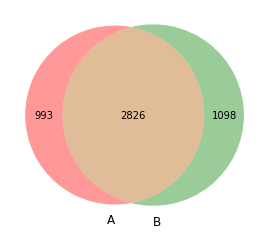

In [13]:
venn2([set(pep_A),set(pep_B)],['A','B'])
plt.show()

In [14]:
intersection = set(pep_A) & set(pep_B)
inter_A = total_A_pep[total_A_pep['peptide'].isin(intersection)]
inter_B = total_B_pep[total_B_pep['peptide'].isin(intersection)]
total = inter_A.join(inter_B.set_index('peptide'),on='peptide',how='outer')
total['avg_A'] = total[['A1','A2','A3','A4','A5']].apply(get_avg_A,axis=1)
total['avg_B'] = total[['B1','B2','B3','B4','B5']].apply(get_avg_B,axis=1)
total['CV_A'] = total[['A1','A2','A3','A4','A5']].apply(get_CV_A,axis=1)
total['CV_B'] = total[['B1','B2','B3','B4','B5']].apply(get_CV_B,axis=1)
old_len = len(total)

In [15]:
def find_label(x):
    charges = [1,2,3,4,5,6,7]
    for charge in charges:
        key = (x,charge)
        if key in library.keys():
            return library[key]['Species']
        else:
            pass
    print('wrong')
    return -1

In [16]:
total['Species'] = total['peptide'].apply(find_label)

In [17]:
species_cnt1 = np.array([len(total[total['Species'] == 'HUMAN']),
                         len(total[total['Species'] == 'YEAS8']),
                         len(total[total['Species'] == 'ECOLI'])])

In [18]:
# total = total[total['CV_A']<=0.2]
# total = total[total['CV_B']<=0.2]

In [19]:
np.sum(species_cnt1)

2826

In [20]:
labels = ['HUMAN', 'YEAS8', 'ECOLI']
print('        before  after   得率')
print('整体', old_len, len(total), round(len(total) / old_len, 2), sep='\t')
species_cnt2 = np.array([len(total[total['Species'] == label]) for label in labels])
print('HUMAN', species_cnt1[0], species_cnt2[0], (species_cnt2 / species_cnt1).round(2)[0], sep='\t')
print('YEAST', species_cnt1[1], species_cnt2[1], (species_cnt2 / species_cnt1).round(2)[1], sep='\t')
print('ECOLI', species_cnt1[2], species_cnt2[2], (species_cnt2 / species_cnt1).round(2)[2], sep='\t')


        before  after   得率
整体	2826	2826	1.0
HUMAN	1958	1958	1.0
YEAST	450	450	1.0
ECOLI	418	418	1.0


In [21]:
total['LogRatio'] = np.log2(list(np.divide(total['avg_A'], total['avg_B'])))
total['LogB'] = np.log2(list(total['avg_B']))

In [22]:
'''计算accuracy（median absolute deviation）'''
print('median absolute deviation')
for label in labels:
    temp = total[total['Species'] == label]
    tertiles = np.percentile(temp['avg_B'], [100 / 3, 200 / 3])  # logB的2个三分位数

    part1 = temp[temp['avg_B'] < tertiles[0]]
    part2 = temp[temp['avg_B'] >= tertiles[0]]
    part2 = part2[part2['avg_B'] < tertiles[1]]
    part3 = temp[temp['avg_B'] >= tertiles[1]]
    parts = [np.array(part1['LogRatio']), np.array(part2['LogRatio']), np.array(part3['LogRatio'])]

    accuracy = []
    for part in parts:
        median = np.median(part)
        accuracy.append(np.round(np.median(np.abs(part - median)), 3))
    print(label, accuracy, 'mean: ' + str(np.mean(accuracy).round(3)), sep='\t')

median absolute deviation
HUMAN	[0.124, 0.113, 0.113]	mean: 0.117
YEAS8	[0.142, 0.137, 0.229]	mean: 0.169
ECOLI	[0.254, 0.184, 0.143]	mean: 0.194


In [23]:
temp = total[total['Species'] == 'HUMAN']
ratios = temp['LogRatio'].values
print(np.mean(ratios))
a = np.median(ratios)-0
print(np.median(ratios)-0)
print(np.std(ratios)/np.mean(ratios))
print(np.round(np.median(np.abs(ratios - np.mean(ratios))), 3))

0.08544154235694092
0.10246789602859616
3.262824008859517
0.117


In [24]:
temp = total[total['Species'] == 'YEAS8']
ratios = temp['LogRatio'].values
print(np.mean(ratios))
b = np.median(ratios)-1
print(np.median(ratios)-1)
print(np.std(ratios)/np.mean(ratios))
print(np.round(np.median(np.abs(ratios - np.mean(ratios))), 3))

0.8585321711329047
-0.03668461239675935
0.5246331440780968
0.194


In [25]:
temp = total[total['Species'] == 'ECOLI']
ratios = temp['LogRatio'].values
print(np.mean(ratios))
c = np.median(ratios)+2
print(np.median(ratios)+2)
print(np.std(ratios)/np.mean(ratios))
print(np.round(np.median(np.abs(ratios - np.mean(ratios))), 3))

-1.576728490805304
0.27517264777746586
-0.3680571211286775
0.267


In [26]:
a

0.10246789602859616

In [27]:
b

-0.03668461239675935

In [28]:
c

0.27517264777746586

In [29]:
(a-b+c)/3

0.13810838540094048

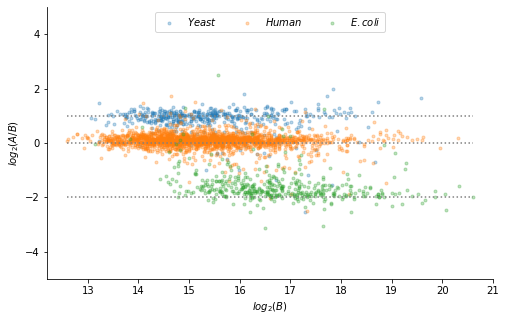

In [30]:
labels = ['$Yeast$', '$Human$', '$E.coli$']
species = ['YEAS8', 'HUMAN', 'ECOLI']
ratios = [1, 0, -2]
# 去掉边框
fig, ax = plt.subplots(figsize=(8,5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in range(len(species)):
    temp = total[total['Species'] == species[i]]

    plt.scatter(temp['LogB'], temp['LogRatio'], marker='.', label=labels[i],alpha = 0.3)
    plt.hlines(y=ratios[i], xmin=min(total['LogB']), xmax=max(total['LogB']), linestyles=':',
               color='gray')  # 水平线：hlines(y, xmin, xmax) 竖直线：vlines(x, ymin, ymax)

plt.xlabel("$log_2(B)$")
plt.ylabel("$log_2(A/B)$")
# plt.xlim((10,25))
plt.ylim((-5, 5))
plt.legend(ncol=3, loc='upper center')  # 图例
plt.show()
#plt.savefig('HYE124_ratio.png')

In [31]:
'''计算accuracy（median absolute deviation）'''
labels = ['HUMAN', 'YEAS8', 'ECOLI']
print('median absolute deviation')
for label in labels:
    temp = total[total['Species'] == label]
    tertiles = np.percentile(temp['avg_B'], [100 / 3, 200 / 3])  # logB的2个三分位数

    part1 = temp[temp['avg_B'] < tertiles[0]]
    part2 = temp[temp['avg_B'] >= tertiles[0]]
    part2 = part2[part2['avg_B'] < tertiles[1]]
    part3 = temp[temp['avg_B'] >= tertiles[1]]
    parts = [np.array(part1['LogRatio']), np.array(part2['LogRatio']), np.array(part3['LogRatio'])]

    accuracy = []
    for part in parts:
        median = np.median(part)
        accuracy.append(np.round(np.median(np.abs(part - median)), 3))
    print(label, accuracy, 'mean: ' + str(np.mean(accuracy).round(3)), sep='\t')

median absolute deviation
HUMAN	[0.124, 0.113, 0.113]	mean: 0.117
YEAS8	[0.142, 0.137, 0.229]	mean: 0.169
ECOLI	[0.254, 0.184, 0.143]	mean: 0.194


In [32]:
label = 'YEAS8'
temp = total[total['Species'] == label]
tertiles = np.percentile(temp['avg_B'], [100 / 3, 200 / 3])  # logB的2个三分位数

part1 = temp[temp['avg_B'] < tertiles[0]]
part2 = temp[temp['avg_B'] >= tertiles[0]]
part2 = part2[part2['avg_B'] < tertiles[1]]
part3 = temp[temp['avg_B'] >= tertiles[1]]

In [33]:
names = locals()
labels = ['HUMAN', 'YEAS8', 'ECOLI']
for label in labels:
    temp = total[total['Species'] == label]
    tertiles = np.percentile(temp['avg_B'], [100 / 3, 200 / 3])  # logB的2个三分位数

    part1 = temp[temp['avg_B'] < tertiles[0]]
    part2 = temp[temp['avg_B'] >= tertiles[0]]
    part2 = part2[part2['avg_B'] < tertiles[1]]
    part3 = temp[temp['avg_B'] >= tertiles[1]]

    for i in range(1,4):
        names[label+str(i)] = np.histogram(names['part'+str(i)]['LogRatio'].values,bins=np.linspace(-4.5,3.5,9))[0]
        names[label+str(i)] = names[label+str(i)][::-1]
        names[label+str(i)] = names[label+str(i)]/np.sum(names[label+str(i)])*100

In [34]:
names[label+str(i)][::-1]

array([ 0.        ,  1.43884892, 83.45323741, 12.23021583,  2.15827338,
        0.71942446,  0.        ,  0.        ])

In [35]:
names = locals()
labels = ['HUMAN', 'YEAS8', 'ECOLI']
for label in labels:
    temp = total[total['Species'] == label]
    names[label] = np.histogram(temp['LogRatio'].values,bins=np.linspace(-4.5,3.5,9))[0]
    names[label] = names[label][::-1]
    names[label] = names[label]/np.sum(names[label])*100

In [36]:
np.linspace(-4.5,3.5,9)

array([-4.5, -3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5])

In [37]:
data = [YEAS81,YEAS82,YEAS83,YEAS8,HUMAN1,HUMAN2,HUMAN3,HUMAN,ECOLI1,ECOLI2,ECOLI3,ECOLI]

In [38]:
data = np.array(data).T

In [39]:
data.shape

(8, 12)

In [40]:
row_label = ["[-4.5,-3.5)","[-3.5,-2.5)","[-2.5,-1.5)","[-1.5,-0.5)","[-0.5,0.5)","[0.5,1.5)","[1.5,2.5)","[2.5,3.5]"]
row_label = row_label[::-1]
col_label = [
    'YEAST_lower','YEAST_middle','YEAST_upper','YEAST',
    'HUMAN_lower','HUMAN_middle','HUMAN_upper','HUMAN',
    'ECOLI_lower','ECOLI_middle','ECOLI_upper','ECOLI'
]

In [41]:
def heatmap(data, row_labels,col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax,fraction=0.030, pad=0.04, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)
    ax.set_yticks(np.arange(data.shape[0]))

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

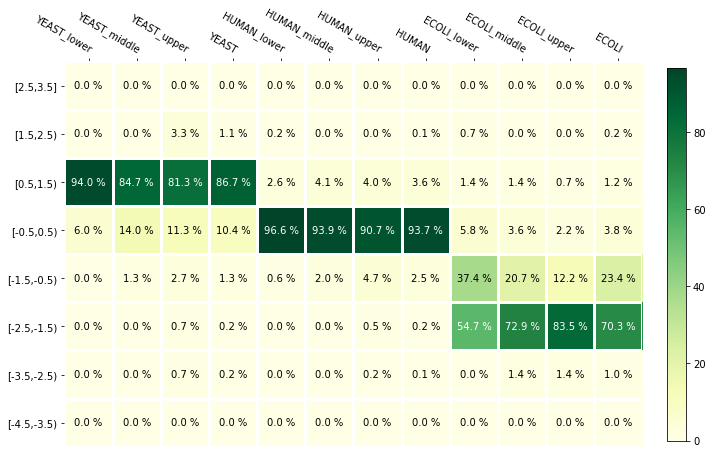

In [42]:
fig, ax = plt.subplots(figsize=(10,10))

im, cbar = heatmap(data, row_label,col_label, ax=ax,
                   cmap="YlGn")

texts = annotate_heatmap(im, valfmt="{x:.1f} %")

fig.tight_layout()
plt.show()

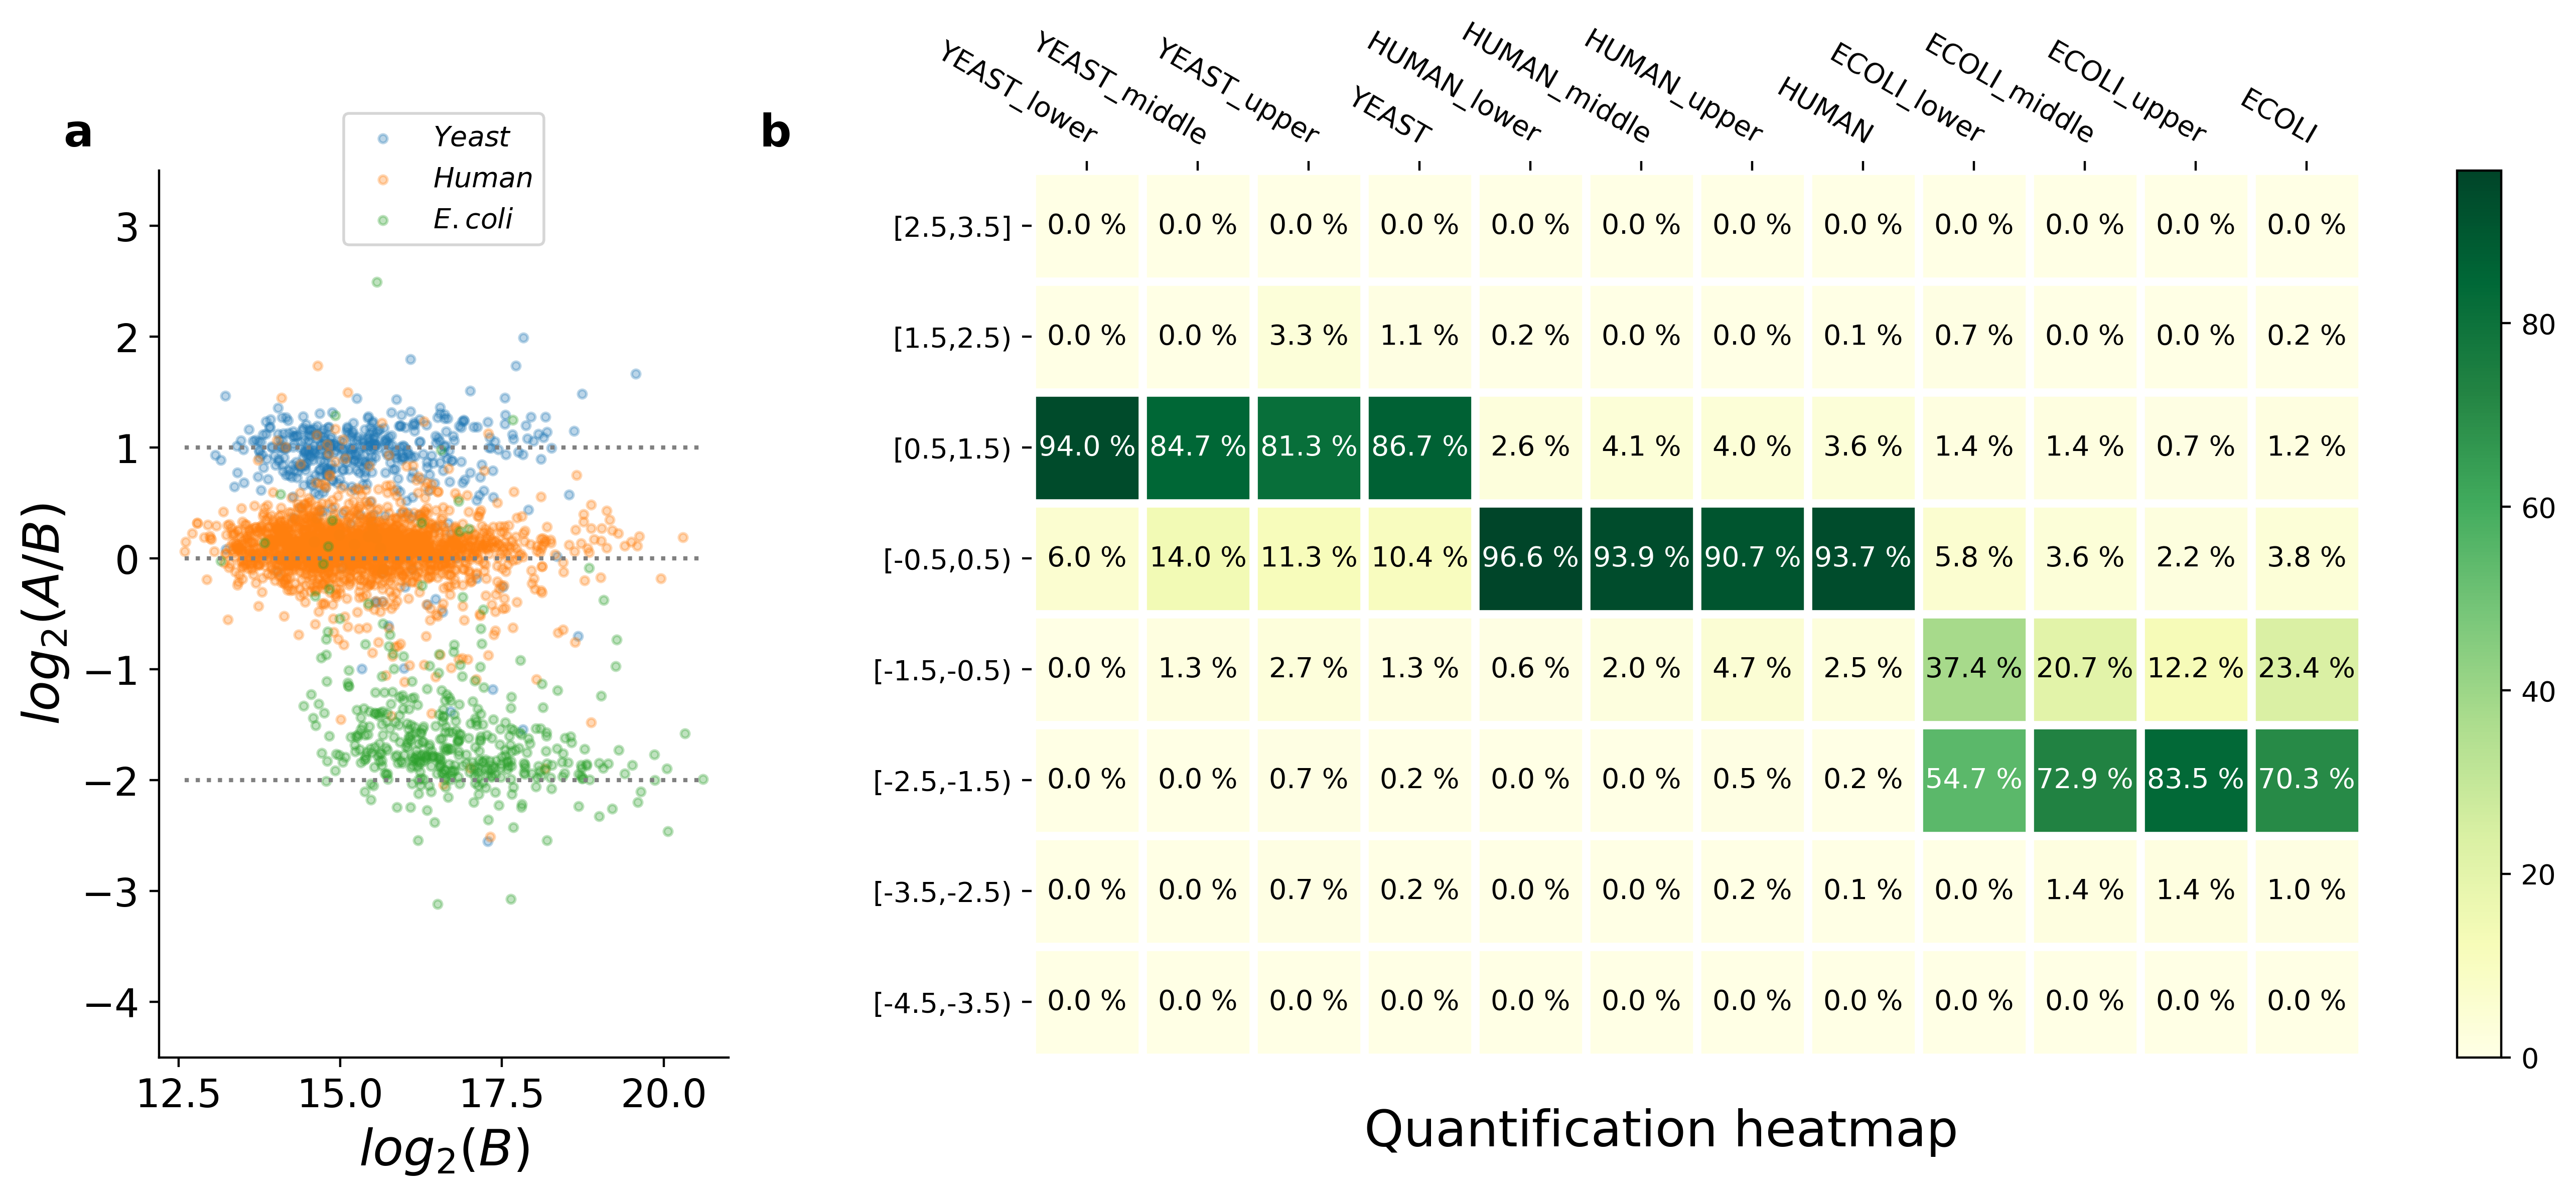

In [43]:
fig = plt.figure(figsize=(13,7),dpi=400)
ax1 = fig.add_subplot(1,4,1)
ax2 = fig.add_subplot(1,1,1)

labels = ['$Yeast$', '$Human$', '$E.coli$']
species = ['YEAS8', 'HUMAN', 'ECOLI']
ratios = [1, 0, -2]
# 去掉边框
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

for i in range(len(species)):
    temp = total[total['Species'] == species[i]]

    ax1.scatter(temp['LogB'], temp['LogRatio'], marker='.', label=labels[i],alpha = 0.3)
    ax1.hlines(y=ratios[i], xmin=min(total['LogB']), xmax=max(total['LogB']), linestyles=':',
               color='gray')  # 水平线：hlines(y, xmin, xmax) 竖直线：vlines(x, ymin, ymax)

    
ax1.set_xlabel("$log_2(B)$",fontsize=18)
ax1.set_ylabel("$log_2(A/B)$",fontsize=18)
ax1.tick_params(labelsize=14)

ax1.set_ylim((-4.5, 3.5))
ax1.legend(ncol=1, loc='upper center', bbox_to_anchor=(0.5, 1.08))  # 图例
# ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.11),fancybox=True, shadow=True, ncol=3,fontsize=14)
ax1.text(0.1, 5.0, 'a', transform=ax.transAxes, size=16, weight='bold')
####################
im, cbar = heatmap(data, row_label,col_label, ax=ax2,
                   cmap="YlGn")

texts = annotate_heatmap(im, valfmt="{x:.1f} %")
ax2.text(0.25, -0.1, 'Quantification heatmap', transform=ax2.transAxes, size=18)
fig.tight_layout()


    # ax.imshow(np.random.randn(10,10), interpolation='none')    
ax2.text(2.5, 5.0, 'b', transform=ax.transAxes, size=16, weight='bold')
plt.savefig('supplement6.jpg')